## Import all necessary modules

In [1]:
import math, os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

## Prepare folder for data

In [2]:
# check if the folders for ExperimentalData exists; if not, create one
Path('./ExperimentalData/').mkdir(parents=True, exist_ok=True)
Path('./CompiledData/').mkdir(parents=True, exist_ok=True)
list_of_folders = ['AC','OSA','OSC','RF']
for i in list_of_folders:
    Path('./ExperimentalData/'+i+'/').mkdir(parents=True, exist_ok=True)


**Remember to place all data files in their corresponding folders before proceeding!**

## Read data in "ExperimentalData" folder

In [66]:
# assign path and make a list of all files in directory
# dirs will be the list of all folders (can use list_of_folders instead)....................................................................................................
path, dirs, files = next(os.walk("./ExperimentalData/"))
file_count = len(files)
Files=[]

# this is to keep track of the directories of all the data files ('dis' is not a typo)
for i in range(len(dirs)):
    path, dis, files = next(os.walk("./ExperimentalData/"+dirs[i]))
    Files.append(files)
    file_count = file_count + len(files)

# create empty list
dataframes_list = []
 
# append datasets to the list 
for k in range(len(dirs)):
    temp_df = []
    for i in range(len(Files[k])):
        # checks the AUTOCORRELATOR folder for txt files then append 
        if dirs[k] == 'AC' and Files[k][i].endswith('.txt'):
            data=[]
            with open('./ExperimentalData/'+dirs[k]+'/'+Files[k][i]) as file:
                for line in file:
                    if line.startswith("#") == False:
                        line = line.strip().split('\t')
                        if is_number(line[0]):
                            data.append(float(x) for x in line)
                        else:
                            cname = line   
                temp_df = pd.DataFrame(data,columns=cname)
                temp_df.index = range(len(temp_df))
                # add normalisation into data (min-max feature scaling method)
                temp_df['NormInt'] = (temp_df['Intensity [arb.u.]'] - temp_df['Intensity [arb.u.]'].min()) \
                / (temp_df['Intensity [arb.u.]'].max() - temp_df['Intensity [arb.u.]'].min())
                temp_df['NormFit'] = (temp_df['Fit [arb.u.]'] - temp_df['Intensity [arb.u.]'].min()) \
                / (temp_df['Intensity [arb.u.]'].max() - temp_df['Intensity [arb.u.]'].min())
                row_index = (temp_df == 1).any(axis=1).idxmax()
                row = temp_df.loc[row_index]
                temp_df['Delay [ps]'] = temp_df['Delay [ps]'] - row['Delay [ps]']
                dataframes_list.append(temp_df)
        # checks the OSA folder for CSV files then append 
        elif dirs[k] == 'OSA' and Files[k][i].endswith('.CSV'):
            data = []
            with open('./ExperimentalData/'+dirs[k]+'/'+Files[k][i]) as f:
                section = ''
                for line in f:
                    if line.strip() == '"[TRACE DATA]"':
                        section = 'data'
                    elif section == 'data':
                        data.append([float(x) for x in line.strip().split(',')])
                if i == 0:
                    temp_df = pd.DataFrame(data, columns=['Wavelength' + str(i) + ' (nm)', 'Intensity' + str(i) + ' (dBm)'])
                else:
                    temp_df = temp_df.join(pd.DataFrame(data, columns=['Wavelength' + str(i) + ' (nm)', 'Intensity' + str(i) + ' (dBm)']))
        # checks the OSCILLOSCOPE folder for files then append 
        elif dirs[k] == 'OSC':
            data = []
            with open('./ExperimentalData/'+dirs[k]+'/'+Files[k][i]) as f:
                for line in f:
                    line = line.strip().split(',')
                    if is_number(line[0]):
                        data.append([float(x) for x in line])
                if i == 0:
                    temp_df = pd.DataFrame(data, columns=['Time' + str(i) + ' (s)','Voltage' + str(i) + ' (V)'])
                else:
                    temp_df = temp_df.join(pd.DataFrame(data, columns=['Time' + str(i) + ' (s)','Voltage' + str(i) + ' (V)']))
        # checks the RFSPECTRUM folder for csv files then append 
        elif dirs[k] == 'RF' and Files[k][i].endswith('.csv'):
            with open('./ExperimentalData/'+dirs[k]+'/'+Files[k][i]) as f:
                data=[]
                section = ''
                for line in f:
                    if line == '\n':
                        section = 'data'
                    elif section == 'data':
                        line = line.strip().split(',')
                        while('' in line):
                            line.remove('')
                        if is_number(line[0]):
                            data.append(float(x) for x in line)
                if i == 0:
                    temp_df = pd.DataFrame(data,columns=['Frequency' + str(i) + ' (Hz)','Maximum' + str(i) + ' (dBm)', 'Minimum' + str(i) + ' (dBm)'])
                else:
                    temp_df = temp_df.join(pd.DataFrame(data,columns=['Frequency' + str(i) + ' (Hz)','Maximum' + str(i) + ' (dBm)', 'Minimum' + str(i) + ' (dBm)']))
    dataframes_list.append(temp_df)  

# display datasets
# for dataset in dataframes_list:
#    display(dataset)

In [47]:
# input the type of file that needs to be compiled ('AC','OSA','OSC','RF')
filetype = 'OSA'

# set compile data save location
compilefilelocation = './CompiledData/'
dataframes_list[dirs.index(filetype)].to_csv(compilefilelocation + 'Compile' + filetype + '.csv', index=False )

In [68]:
dataframes_list[3]

,Time0 (s),Voltage0 (V),Time1 (s),Voltage1 (V)
0,-0.000170,0.000275,-2.400000e-07,0.005199
1,-0.000170,0.000474,-2.398000e-07,0.002855
2,-0.000170,0.000545,-2.396000e-07,0.000707
3,-0.000169,0.000397,-2.394000e-07,-0.003395
4,-0.000169,0.000346,-2.392000e-07,-0.007887
...,...,...,...,...
1995,0.000169,0.000409,1.590000e-07,-0.002027
1996,0.000169,0.000334,1.592000e-07,-0.001832
1997,0.000169,0.000407,1.594000e-07,-0.001637
1998,0.000170,0.000373,1.596000e-07,-0.000855


<Axes: xlabel='Delay [ps]', ylabel='NormInt'>

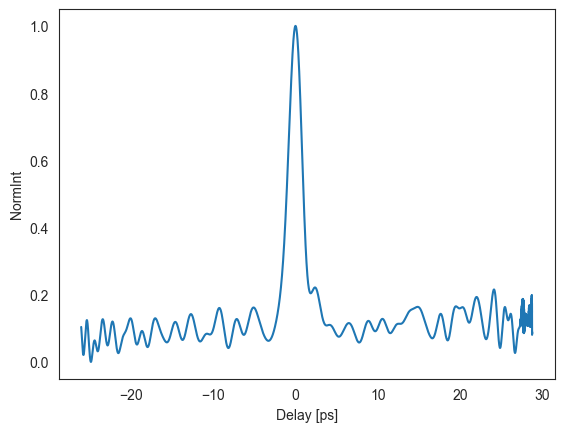

In [57]:
sns.set_style("white")
sns.lineplot(dataframes_list[0],x="Delay [ps]",y="NormInt")